<a href="https://colab.research.google.com/github/yyguo50170/dlg/blob/main/Deep_Leakage_from_Gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)

2.0.1+cu118 0.15.2+cu118


In [10]:
dst = datasets.CIFAR100("~/.torch", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

def dlg_attack(gt_data,gt_onehot_label,net,original_dy_dx,epoch):
    # generate dummy data and label
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

    plt.imshow(tt(dummy_data[0].cpu()))
    plt.title("Dummy data")
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
    optimizer = torch.optim.LBFGS([dummy_data, dummy_label])
    loss_list = []

    history = []
    for iters in range(5000):
        def closure():
            optimizer.zero_grad()

            pred = net(dummy_data)
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            grad_diff = 0
            grad_count = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()
            # grad_diff = grad_diff / grad_count * 1000
            grad_diff.backward()

            return grad_diff

        optimizer.step(closure)
        current_loss = closure()
        loss_list.append(current_loss.item())
        if iters % 10 == 0:
            print(iters, "%.4f" % current_loss.item())
        history.append(tt(dummy_data[0].cpu()))
        if current_loss.item() < 0.0001:
          print("global epoch:{}, converge dlg iters:{}".format(epoch,iters))
          break
    # plt.figure()
    # plt.imshow(history[-1])
    # plt.title("Final dummy data")
    # plt.show()
    print(loss_list)
    plt.figure()
    plt.plot(range(len(loss_list)), loss_list, label='dlg loss')
    plt.title('the loss of dlg task epoch:{}'.format(epoch))
    plt.xlabel('dlg epoch')
    plt.ylabel('loss')
    plt.show()
    #plt.figure(figsize=(12, 8))
    # for i in range(600):
    #   plt.subplot(3, 10, i + 1)
    #   plt.imshow(history[i * 10])
    #   plt.title("iter=%d" % (i * 10))
    #   plt.axis('off')
    # plt.savefig('/content/dlg_cifar100_epoch{}.png'.format(epoch))
    print("Final dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

Files already downloaded and verified
Running on cuda


In [11]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

net = LeNet().to(device)

net.apply(weights_init)
criterion = cross_entropy_for_onehot

Files already downloaded and verified
GT label is 84. 
Onehot label is 84.
epoch:1   Epoch [1/1], Step [700/782], Loss: 4.2481
epoch:2   Epoch [1/1], Step [700/782], Loss: 4.0240
dlg epoch: 3
Dummy label is 64.
0 18.7087
10 0.2707
20 0.0385
30 0.0083
40 0.0022
50 0.0008
60 0.0003
70 0.0001
global epoch:2, converge dlg iters:72
[18.708694458007812, 7.2824177742004395, 3.937943935394287, 2.48115611076355, 1.653377652168274, 1.1685899496078491, 0.8204022645950317, 0.604547917842865, 0.4523465931415558, 0.3507836163043976, 0.27071312069892883, 0.2113770693540573, 0.16684755682945251, 0.13681836426258087, 0.1126164048910141, 0.09423141181468964, 0.07749979197978973, 0.06494460999965668, 0.05483037605881691, 0.04513062536716461, 0.03848874196410179, 0.03209180012345314, 0.02780301868915558, 0.023633914068341255, 0.020164471119642258, 0.01742732897400856, 0.014961089007556438, 0.012713395059108734, 0.011119063012301922, 0.009441165253520012, 0.008256079629063606, 0.007178648374974728, 0.00625

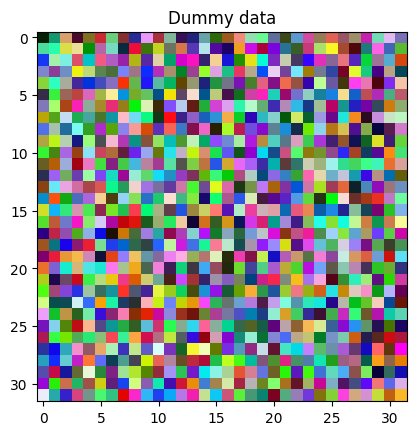

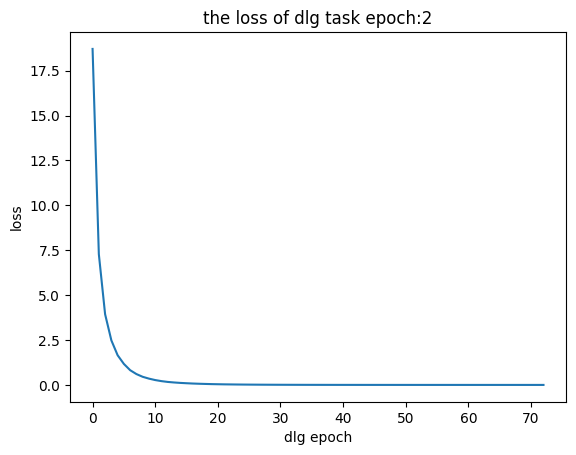

Final dummy label is 84.
epoch:4   Epoch [1/1], Step [700/782], Loss: 3.6613
epoch:5   Epoch [1/1], Step [700/782], Loss: 3.5820
epoch:6   Epoch [1/1], Step [700/782], Loss: 3.5639
epoch:7   Epoch [1/1], Step [700/782], Loss: 3.1288
epoch:8   Epoch [1/1], Step [700/782], Loss: 3.0227
epoch:9   Epoch [1/1], Step [700/782], Loss: 3.0940
epoch:10   Epoch [1/1], Step [700/782], Loss: 3.1217
epoch:11   Epoch [1/1], Step [700/782], Loss: 2.9521
epoch:12   Epoch [1/1], Step [700/782], Loss: 3.3549
epoch:13   Epoch [1/1], Step [700/782], Loss: 3.2273
epoch:14   Epoch [1/1], Step [700/782], Loss: 2.5861
epoch:15   Epoch [1/1], Step [700/782], Loss: 2.9813
epoch:16   Epoch [1/1], Step [700/782], Loss: 2.9977
epoch:17   Epoch [1/1], Step [700/782], Loss: 2.7194
epoch:18   Epoch [1/1], Step [700/782], Loss: 3.3004
epoch:19   Epoch [1/1], Step [700/782], Loss: 2.9249
epoch:20   Epoch [1/1], Step [700/782], Loss: 2.7879
epoch:21   Epoch [1/1], Step [700/782], Loss: 2.8985
epoch:22   Epoch [1/1], Ste

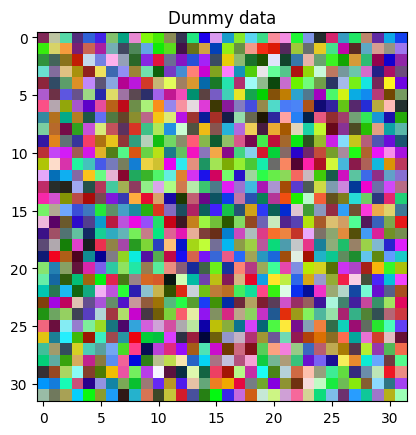

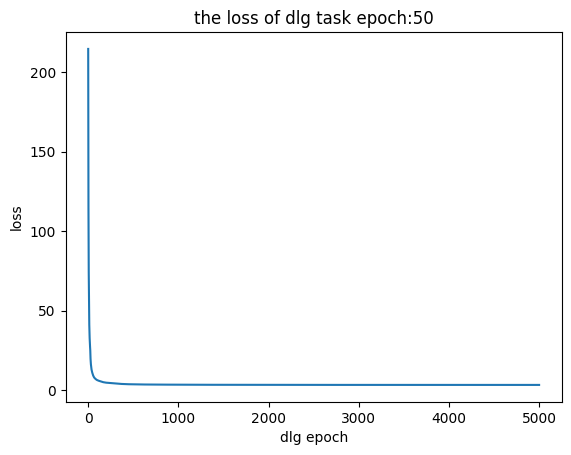

Final dummy label is 84.
epoch:52   Epoch [1/1], Step [700/782], Loss: 2.3412
epoch:53   Epoch [1/1], Step [700/782], Loss: 2.4361
epoch:54   Epoch [1/1], Step [700/782], Loss: 2.1620
epoch:55   Epoch [1/1], Step [700/782], Loss: 2.3085
epoch:56   Epoch [1/1], Step [700/782], Loss: 2.2029
epoch:57   Epoch [1/1], Step [700/782], Loss: 2.4092
epoch:58   Epoch [1/1], Step [700/782], Loss: 2.1929
epoch:59   Epoch [1/1], Step [700/782], Loss: 2.3239
epoch:60   Epoch [1/1], Step [700/782], Loss: 2.2151
epoch:61   Epoch [1/1], Step [700/782], Loss: 2.1336
epoch:62   Epoch [1/1], Step [700/782], Loss: 1.9203
epoch:63   Epoch [1/1], Step [700/782], Loss: 2.1423
epoch:64   Epoch [1/1], Step [700/782], Loss: 1.8722
epoch:65   Epoch [1/1], Step [700/782], Loss: 2.1058
epoch:66   Epoch [1/1], Step [700/782], Loss: 1.8554
epoch:67   Epoch [1/1], Step [700/782], Loss: 2.0699
epoch:68   Epoch [1/1], Step [700/782], Loss: 1.6838
epoch:69   Epoch [1/1], Step [700/782], Loss: 1.9497
epoch:70   Epoch [1/1

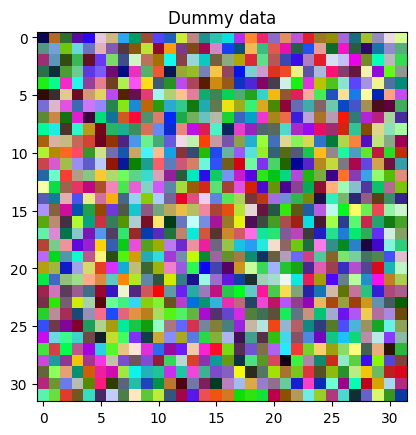

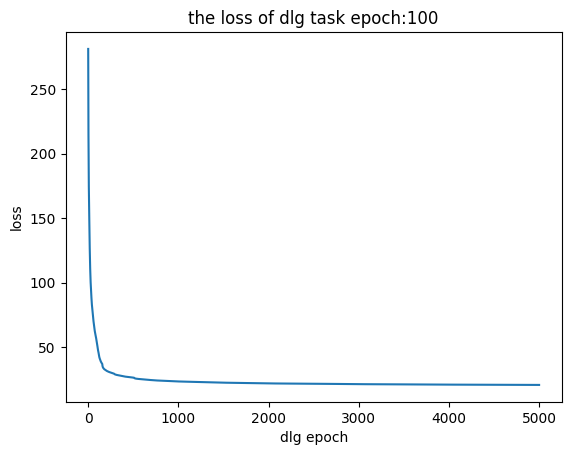

Final dummy label is 84.
epoch:102   Epoch [1/1], Step [700/782], Loss: 1.5064
epoch:103   Epoch [1/1], Step [700/782], Loss: 1.6599
epoch:104   Epoch [1/1], Step [700/782], Loss: 1.7180
epoch:105   Epoch [1/1], Step [700/782], Loss: 1.7265
epoch:106   Epoch [1/1], Step [700/782], Loss: 1.4969
epoch:107   Epoch [1/1], Step [700/782], Loss: 2.0558
epoch:108   Epoch [1/1], Step [700/782], Loss: 1.6864
epoch:109   Epoch [1/1], Step [700/782], Loss: 1.3879
epoch:110   Epoch [1/1], Step [700/782], Loss: 1.7750
epoch:111   Epoch [1/1], Step [700/782], Loss: 1.9767
epoch:112   Epoch [1/1], Step [700/782], Loss: 1.3966
epoch:113   Epoch [1/1], Step [700/782], Loss: 1.8687
epoch:114   Epoch [1/1], Step [700/782], Loss: 1.8161
epoch:115   Epoch [1/1], Step [700/782], Loss: 1.8936
epoch:116   Epoch [1/1], Step [700/782], Loss: 1.7080
epoch:117   Epoch [1/1], Step [700/782], Loss: 1.8989
epoch:118   Epoch [1/1], Step [700/782], Loss: 2.1413
epoch:119   Epoch [1/1], Step [700/782], Loss: 1.6611
epo

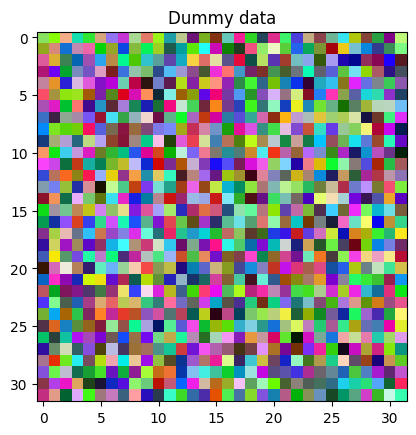

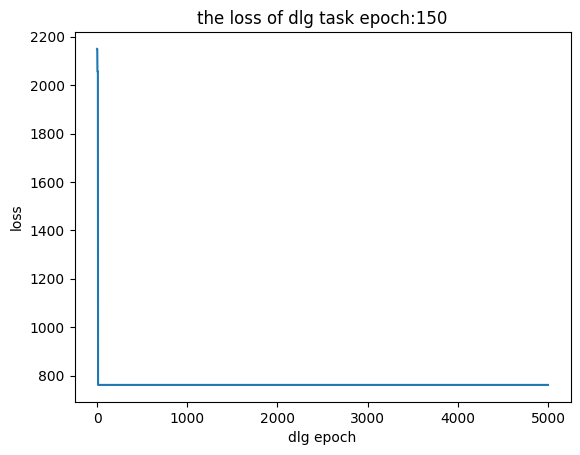

Final dummy label is 16.
epoch:152   Epoch [1/1], Step [700/782], Loss: 1.4981
epoch:153   Epoch [1/1], Step [700/782], Loss: 1.7912
epoch:154   Epoch [1/1], Step [700/782], Loss: 1.4377
epoch:155   Epoch [1/1], Step [700/782], Loss: 1.4494
epoch:156   Epoch [1/1], Step [700/782], Loss: 1.8154
epoch:157   Epoch [1/1], Step [700/782], Loss: 1.4484
epoch:158   Epoch [1/1], Step [700/782], Loss: 1.7458
epoch:159   Epoch [1/1], Step [700/782], Loss: 1.6207
epoch:160   Epoch [1/1], Step [700/782], Loss: 1.6044
epoch:161   Epoch [1/1], Step [700/782], Loss: 1.9017
epoch:162   Epoch [1/1], Step [700/782], Loss: 1.5017
epoch:163   Epoch [1/1], Step [700/782], Loss: 1.5416
epoch:164   Epoch [1/1], Step [700/782], Loss: 1.2163
epoch:165   Epoch [1/1], Step [700/782], Loss: 1.4113
epoch:166   Epoch [1/1], Step [700/782], Loss: 1.7493
epoch:167   Epoch [1/1], Step [700/782], Loss: 1.6705
epoch:168   Epoch [1/1], Step [700/782], Loss: 1.6693
epoch:169   Epoch [1/1], Step [700/782], Loss: 1.8321
epo

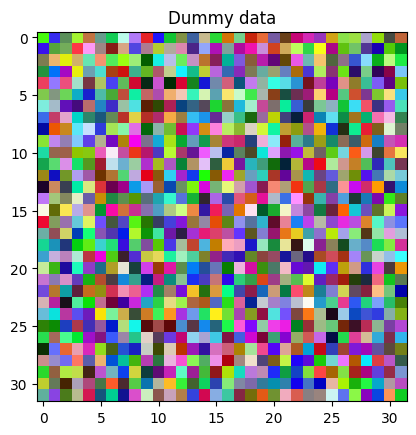

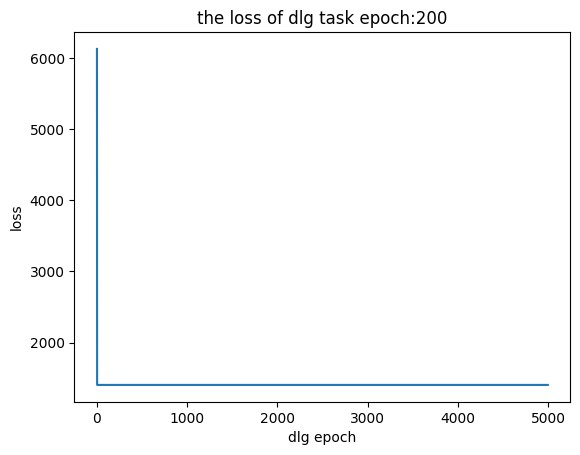

Final dummy label is 72.
epoch:202   Epoch [1/1], Step [700/782], Loss: 1.3388
epoch:203   Epoch [1/1], Step [700/782], Loss: 1.2432
epoch:204   Epoch [1/1], Step [700/782], Loss: 1.6692
epoch:205   Epoch [1/1], Step [700/782], Loss: 1.2332
epoch:206   Epoch [1/1], Step [700/782], Loss: 1.5258
epoch:207   Epoch [1/1], Step [700/782], Loss: 1.4797
epoch:208   Epoch [1/1], Step [700/782], Loss: 1.6104
epoch:209   Epoch [1/1], Step [700/782], Loss: 1.2835
epoch:210   Epoch [1/1], Step [700/782], Loss: 1.4354
epoch:211   Epoch [1/1], Step [700/782], Loss: 1.4670
epoch:212   Epoch [1/1], Step [700/782], Loss: 1.1543
epoch:213   Epoch [1/1], Step [700/782], Loss: 1.5097
epoch:214   Epoch [1/1], Step [700/782], Loss: 1.4309
epoch:215   Epoch [1/1], Step [700/782], Loss: 1.7240
epoch:216   Epoch [1/1], Step [700/782], Loss: 1.4025
epoch:217   Epoch [1/1], Step [700/782], Loss: 1.3718
epoch:218   Epoch [1/1], Step [700/782], Loss: 1.3969
epoch:219   Epoch [1/1], Step [700/782], Loss: 1.5197
epo

In [ ]:
######### honest partipant #########

# Hyper-parameters
epochs = 1000
local_eoochs = 1
batch_size = 64
learning_rate = 0.001

# CIFAR-100 dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

#train_dataset = datasets.CIFAR100(root='./torch', train=True, transform=transform, download=True)
train_dataset = datasets.CIFAR100(root='./torch', train=True, transform=tp, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

train_criterion = nn.CrossEntropyLoss()
train_optimizer = optim.Adam(net.parameters(), lr=learning_rate)



#攻击用数据
img_index = 25
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())
for i in range(epochs):
  if i not in[2,50,100,150,200]:
    # Train the model
    total_step = len(train_loader)
    for local_epoch in range(local_eoochs):
      for j, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)

          # Forward pass
          outputs = net(images)
          loss = train_criterion(outputs, labels)

          # Backward and optimize
          train_optimizer.zero_grad()
          loss.backward()
          train_optimizer.step()

          if (j+1) % 700 == 0:
              print ('epoch:{}   Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(i+1,local_epoch+1, local_eoochs, j+1, total_step, loss.item()))

  else:

    # img_index = 25
    # gt_data = tp(dst[img_index][0]).to(device)
    # gt_data = gt_data.view(1, *gt_data.size())
    # gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
    # gt_label = gt_label.view(1, )
    # gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

    # plt.imshow(tt(gt_data[0].cpu()))
    # plt.title("Ground truth image")
    # print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

    # compute original gradient
    out = net(gt_data)
    y = criterion(out, gt_onehot_label)
    dy_dx = torch.autograd.grad(y, net.parameters())


    # share the gradients with other clients
    original_dy_dx = list((_.detach().clone() for _ in dy_dx))
    print('dlg epoch:',i+1)
    dlg_attack(gt_data,gt_onehot_label,net,original_dy_dx,i)
    for server_param, grad_param in zip(net.parameters(), dy_dx):
      server_param.data = server_param.data - learning_rate * grad_param.data.clone()


In [ ]:
# generate dummy data and label
# dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
# dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

# plt.imshow(tt(dummy_data[0].cpu()))
# plt.title("Dummy data")
# print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [ ]:
# optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

# history = []
# for iters in range(300):
#     def closure():
#         optimizer.zero_grad()

#         pred = net(dummy_data)
#         dummy_onehot_label = F.softmax(dummy_label, dim=-1)
#         dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
#         dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

#         grad_diff = 0
#         grad_count = 0
#         for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
#             grad_diff += ((gx - gy) ** 2).sum()
#             grad_count += gx.nelement()
#         # grad_diff = grad_diff / grad_count * 1000
#         grad_diff.backward()

#         return grad_diff

#     optimizer.step(closure)
#     if iters % 10 == 0:
#         current_loss = closure()
#         print(iters, "%.4f" % current_loss.item())
#     history.append(tt(dummy_data[0].cpu()))

In [ ]:
# plt.figure(figsize=(12, 8))
# for i in range(30):
#   plt.subplot(3, 10, i + 1)
#   plt.imshow(history[i * 10])
#   plt.title("iter=%d" % (i * 10))
#   plt.axis('off')
# print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())